# ROB 498: Robot Learning for Planning and Control
# Final Project: neuralODE

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW3 folder, then 'ROB498/HW3'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ML4Control/neuralODE'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498/neuralODE'

### Setup Code 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


The below cell will check you have the required files in your directory. The file `mppi.py` will be released on 02/19/2023, so you should expect to see 'Required file `mppi.py` not found!' before then. This is because there may still be students working on Homework 2 until then. This file is not needed until Section 4 of the homework. 

In [4]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
# Install torchdiffeq
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 MB 11.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

In [7]:
# Load the collected data: 
collected_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), allow_pickle=True)
validation_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True)

In [8]:
from learning_state_dynamics import *
from panda_neuralODE import *
from visualizers import GIFVisualizer, NotebookVisualizer
from panda_pushing_env import TARGET_POSE_FREE, TARGET_POSE_OBSTACLES, BOX_SIZE, PandaPushingEnv

In [9]:
if torch.cuda.device_count() > 0:
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

print("Using", DEVICE)

Using cuda


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Planar Pushing Learning



## Learn the Pushing Dynamics


### Absolute neuralODE

In [12]:
# Train the dynamics model
neuralODE_model = Absolute_ODEnet(state_dim=3, action_dim=3, n_steps=10).to(DEVICE)

train_loader, val_loader = process_data_single_step(collected_data, device=DEVICE)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
pose_loss = SingleStepLoss(pose_loss).to(DEVICE)

# --- Your code here
train_losses, val_losses = train_nODE_model(neuralODE_model, 
                                            train_loader, 
                                            val_loader, 
                                            pose_loss, 
                                            num_epochs=200, 
                                            lr=1e-3)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_absolute_dynamics_model.pt')
torch.save(neuralODE_model.state_dict(), save_path)


  0%|          | 0/200 [00:00<?, ?it/s]

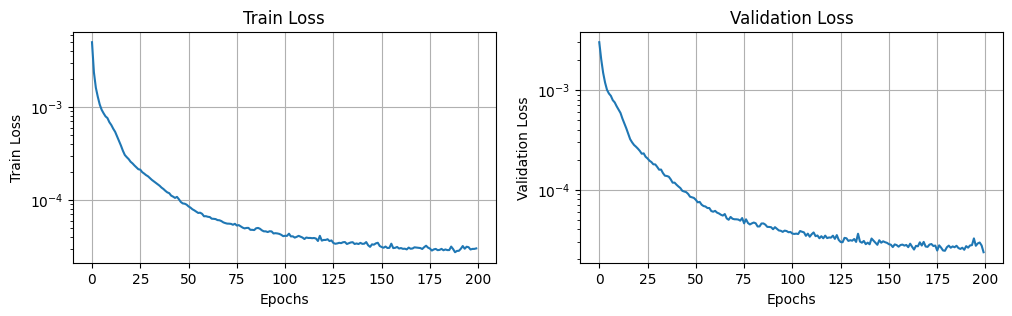

In [13]:
# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].plot(train_losses)
axes[0].grid()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')
axes[1].plot(val_losses)
axes[1].grid()
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Validation Loss')
axes[1].set_yscale('log')

### Residual neuralODE

In [ ]:
# Train the dynamics model
neuralODE_model = Residual_ODEnet(state_dim=3, action_dim=3, n_steps=10).to(DEVICE)

train_loader, val_loader = process_data_single_step(collected_data, device=DEVICE)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
pose_loss = SingleStepLoss(pose_loss).to(DEVICE)

# --- Your code here
train_losses, val_losses = train_nODE_model(neuralODE_model, train_loader, val_loader, pose_loss, num_epochs=200, lr=1e-2)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_residual_dynamics_model_neg1.pt')
torch.save(neuralODE_model.state_dict(), save_path)


  0%|          | 0/200 [00:00<?, ?it/s]

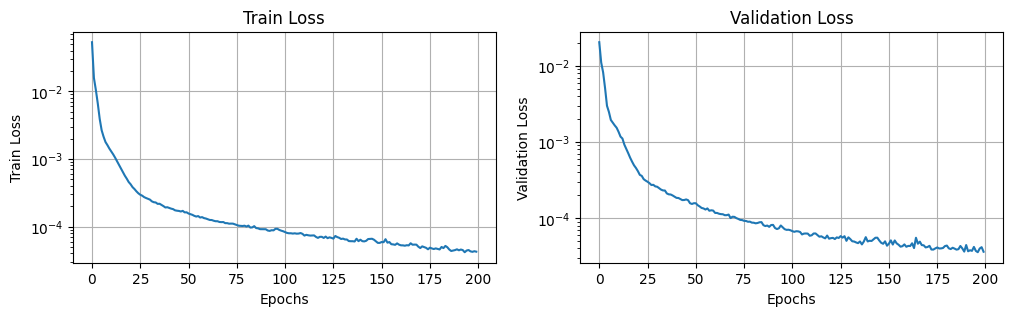

In [ ]:
# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].plot(train_losses)
axes[0].grid()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')
axes[1].plot(val_losses)
axes[1].grid()
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Validation Loss')
axes[1].set_yscale('log')

### 3.1 - Absolute Dynamics Learning (20 points)

In [ ]:
# Train the dynamics model
pushing_absolute_dynamics_model = AbsoluteDynamicsModel(3,3)

train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here
train_model(pushing_absolute_dynamics_model, train_loader, val_loader, pose_loss, num_epochs=200, lr=1e-3)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_absolute_dynamics_model.pt')
torch.save(pushing_absolute_dynamics_model.state_dict(), save_path)



Train Loss: 0.0001 | Validation Loss: 0.0001: 100%|██████████| 200/200 [00:14<00:00, 13.93it/s]


### 3.2 - Residual Dynamics Learning (10 points)

In [ ]:
pushing_residual_dynamics_model = ResidualDynamicsModel(3,3)
train_loader, val_loader = process_data_single_step(collected_data)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = SingleStepLoss(pose_loss)

# --- Your code here
train_model(pushing_residual_dynamics_model, train_loader, val_loader, pose_loss, num_epochs=200, lr=1e-3)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_residual_dynamics_model.pt')
torch.save(pushing_residual_dynamics_model.state_dict(), save_path)

Train Loss: 0.0000 | Validation Loss: 0.0000: 100%|██████████| 200/200 [00:14<00:00, 13.85it/s]


### Compare SingleStepLoss models

In [14]:
pushing_absolute_dynamics_model = AbsoluteDynamicsModel(3,3).to(DEVICE)
pushing_absolute_dynamics_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_absolute_dynamics_model.pt')))

pushing_residual_dynamics_model = ResidualDynamicsModel(3,3).to(DEVICE)
pushing_residual_dynamics_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_residual_dynamics_model.pt')))

absolute_neuralODE_model = Absolute_ODEnet(3,3,10).to(DEVICE)
absolute_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_absolute_dynamics_model.pt')))

residual_neuralODE_model = Residual_ODEnet(3,3,10).to(DEVICE)
residual_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_residual_dynamics_model_neg1.pt')))

<All keys matched successfully>

In [15]:
val_dataset = SingleStepDynamicsDataset(np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True), device=DEVICE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
pose_loss = SingleStepLoss(pose_loss).to(DEVICE)

loss_absolute = 0.0
loss_residual = 0.0
loss_absolute_ode = 0.0
loss_residual_ode = 0.0

for item in val_loader:
    loss_absolute += pose_loss(pushing_absolute_dynamics_model, item['state'], item['action'], item['next_state'])
    loss_residual += pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])
    loss_absolute_ode += pose_loss(absolute_neuralODE_model, item['state'], item['action'], item['next_state'])
    loss_residual_ode += pose_loss(residual_neuralODE_model, item['state'], item['action'], item['next_state'])

print(f'Validation loss for absolute           dynamics model is {loss_absolute}')
print(f'Validation loss for residual           dynamics model is {loss_residual}')
print(f'Validation loss for absolute neuralODE dynamics model is {loss_absolute_ode}')
print(f'Validation loss for residual neuralODE dynamics model is {loss_residual_ode}')

Validation loss for absolute           dynamics model is 0.00012110961688449606
Validation loss for residual           dynamics model is 7.089226710377261e-05
Validation loss for absolute neuralODE dynamics model is 5.647807483910583e-05
Validation loss for residual neuralODE dynamics model is 6.987394590396434e-05


### 3.4 Multi-step Loss

In [ ]:
# Train the dynamics model
neuralODE_multistep_dynamics_model = Residual_ODEnet(state_dim=3, action_dim=3, n_steps=10).to(DEVICE)

train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500, device=DEVICE)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
pose_loss = MultiStepLoss(pose_loss, discount=0.9).to(DEVICE)

# --- Your code here
train_nODE_model(neuralODE_multistep_dynamics_model, train_loader, val_loader, pose_loss, num_epochs=200, lr=1e-2)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_multi_step_residual_dynamics_model_neg1.pt')
torch.save(neuralODE_multistep_dynamics_model.state_dict(), save_path)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Train the dynamics model
from learning_state_dynamics import MultiStepLoss, process_data_multiple_step
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
pose_loss = MultiStepLoss(pose_loss, discount=0.9)

# --- Your code here
train_model(pushing_multistep_residual_dynamics_model, train_loader, val_loader, pose_loss, num_epochs=200, lr=1e-3)
# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'pushing_multi_step_residual_dynamics_model.pt')
torch.save(pushing_multistep_residual_dynamics_model.state_dict(), save_path)

Train Loss: 0.0004 | Validation Loss: 0.0005: 100%|██████████| 200/200 [00:21<00:00,  9.44it/s]


### Compare Multistep Loss Models

In [ ]:
multistep_residual_dynamics_model = ResidualDynamicsModel(3,3).to(DEVICE)
multistep_residual_dynamics_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_multi_step_residual_dynamics_model.pt')))

multistep_absolute_neuralODE_model = Absolute_ODEnet(state_dim=3, action_dim=3, n_steps=10).to(DEVICE)
multistep_absolute_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_multi_step_dynamics_model.pt'), map_location=torch.device(DEVICE)))

multistep_residual_neuralODE_model = Residual_ODEnet(state_dim=3, action_dim=3, n_steps=10).to(DEVICE)
multistep_residual_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_multi_step_residual_dynamics_model_neg1.pt'), map_location=torch.device(DEVICE)))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [ ]:
val_dataset = MultiStepDynamicsDataset(np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True), device=DEVICE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
pose_loss = MultiStepLoss(pose_loss).to(DEVICE)

loss_residual = 0.0
loss_absolute_ode = 0.0
loss_residual_ode = 0.0

for item in val_loader:
    loss_residual += pose_loss(multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])
    loss_absolute_ode += pose_loss(multistep_absolute_neuralODE_model, item['state'], item['action'], item['next_state'])
    loss_residual_ode += pose_loss(multistep_residual_neuralODE_model, item['state'], item['action'], item['next_state'])

print(f'Validation loss for residual           dynamics model is {loss_residual}')
print(f'Validation loss for absolute neuralODE dynamics model is {loss_absolute_ode}')
print(f'Validation loss for residual neuralODE dynamics model is {loss_residual_ode}')

Validation loss for residual           dynamics model is 0.0010421071201562881
Validation loss for absolute neuralODE dynamics model is 3.1643857955932617
Validation loss for residual neuralODE dynamics model is 0.0040716128423810005


### 3.5 - Multistep vs Single Step Loss (No points)

In [ ]:
val_dataset = SingleStepDynamicsDataset(np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

num_steps = 4
val_multistep_dataset = MultiStepDynamicsDataset(np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True), num_steps=num_steps)
val_multistep_loader = torch.utils.data.DataLoader(val_multistep_dataset, batch_size=len(val_multistep_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1)
multistep_pose_loss = MultiStepLoss(pose_loss, discount=1)
pose_loss = SingleStepLoss(pose_loss)


single_step_loss_single_step_model = 0.0
single_step_loss_multi_step_model = 0.0

for item in val_loader:
    single_step_loss_single_step_model += \
        pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    single_step_loss_multi_step_model += \
        pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])

print(f'Validation single-step loss for model trained on single-step loss {single_step_loss_single_step_model}')
print(f'Validation single-step loss for model trained on multi-step loss {single_step_loss_multi_step_model}')

multi_step_loss_single_step_model = 0.0
multi_step_loss_multi_step_model = 0.0

for item in val_multistep_loader:
    multi_step_loss_single_step_model += \
        multistep_pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])

    multi_step_loss_multi_step_model += \
        multistep_pose_loss(pushing_multistep_residual_dynamics_model, item['state'], item['action'], item['next_state'])
print('')
print(f'Validation multi-step loss for model trained on single-step loss {multi_step_loss_single_step_model / num_steps}')
print(f'Validation multi-step loss for model trained on multi-step loss {multi_step_loss_multi_step_model / num_steps}')

Validation single-step loss for model trained on single-step loss 7.089224527589977e-05
Validation single-step loss for model trained on multi-step loss 8.656196587253362e-05

Validation multi-step loss for model trained on single-step loss 0.00021714619651902467
Validation multi-step loss for model trained on multi-step loss 0.0002457965456414968


### Compare models

In [17]:
pushing_absolute_dynamics_model = AbsoluteDynamicsModel(3,3).to(DEVICE)
pushing_absolute_dynamics_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_absolute_dynamics_model.pt')))

pushing_residual_dynamics_model = ResidualDynamicsModel(3,3).to(DEVICE)
pushing_residual_dynamics_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_residual_dynamics_model.pt')))

absolute_neuralODE_model = Absolute_ODEnet(3,3,10).to(DEVICE)
absolute_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_absolute_dynamics_model.pt')))

residual_neuralODE_model = Residual_ODEnet(3,3,10).to(DEVICE)
residual_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_residual_dynamics_model_neg1.pt')))

<All keys matched successfully>

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---- Single-step Loss ----
Validation loss for absolute           dynamics model is 0.00012110961688449606
Validation loss for residual           dynamics model is 7.089226710377261e-05
Validation loss for absolute neuralODE dynamics model is 5.647807483910583e-05
Validation loss for residual neuralODE dynamics model is 6.987394590396434e-05

---- Multi-step Loss ----
Validation loss for absolute           dynamics model is 0.0003519713063724339
Validation loss for residual           dynamics model is 0.00021714619651902467
Validation loss for absolute neuralODE dynamics model is 0.00019283565052319318
Validation loss for residual neuralODE dynamics model is 0.000236954860156402


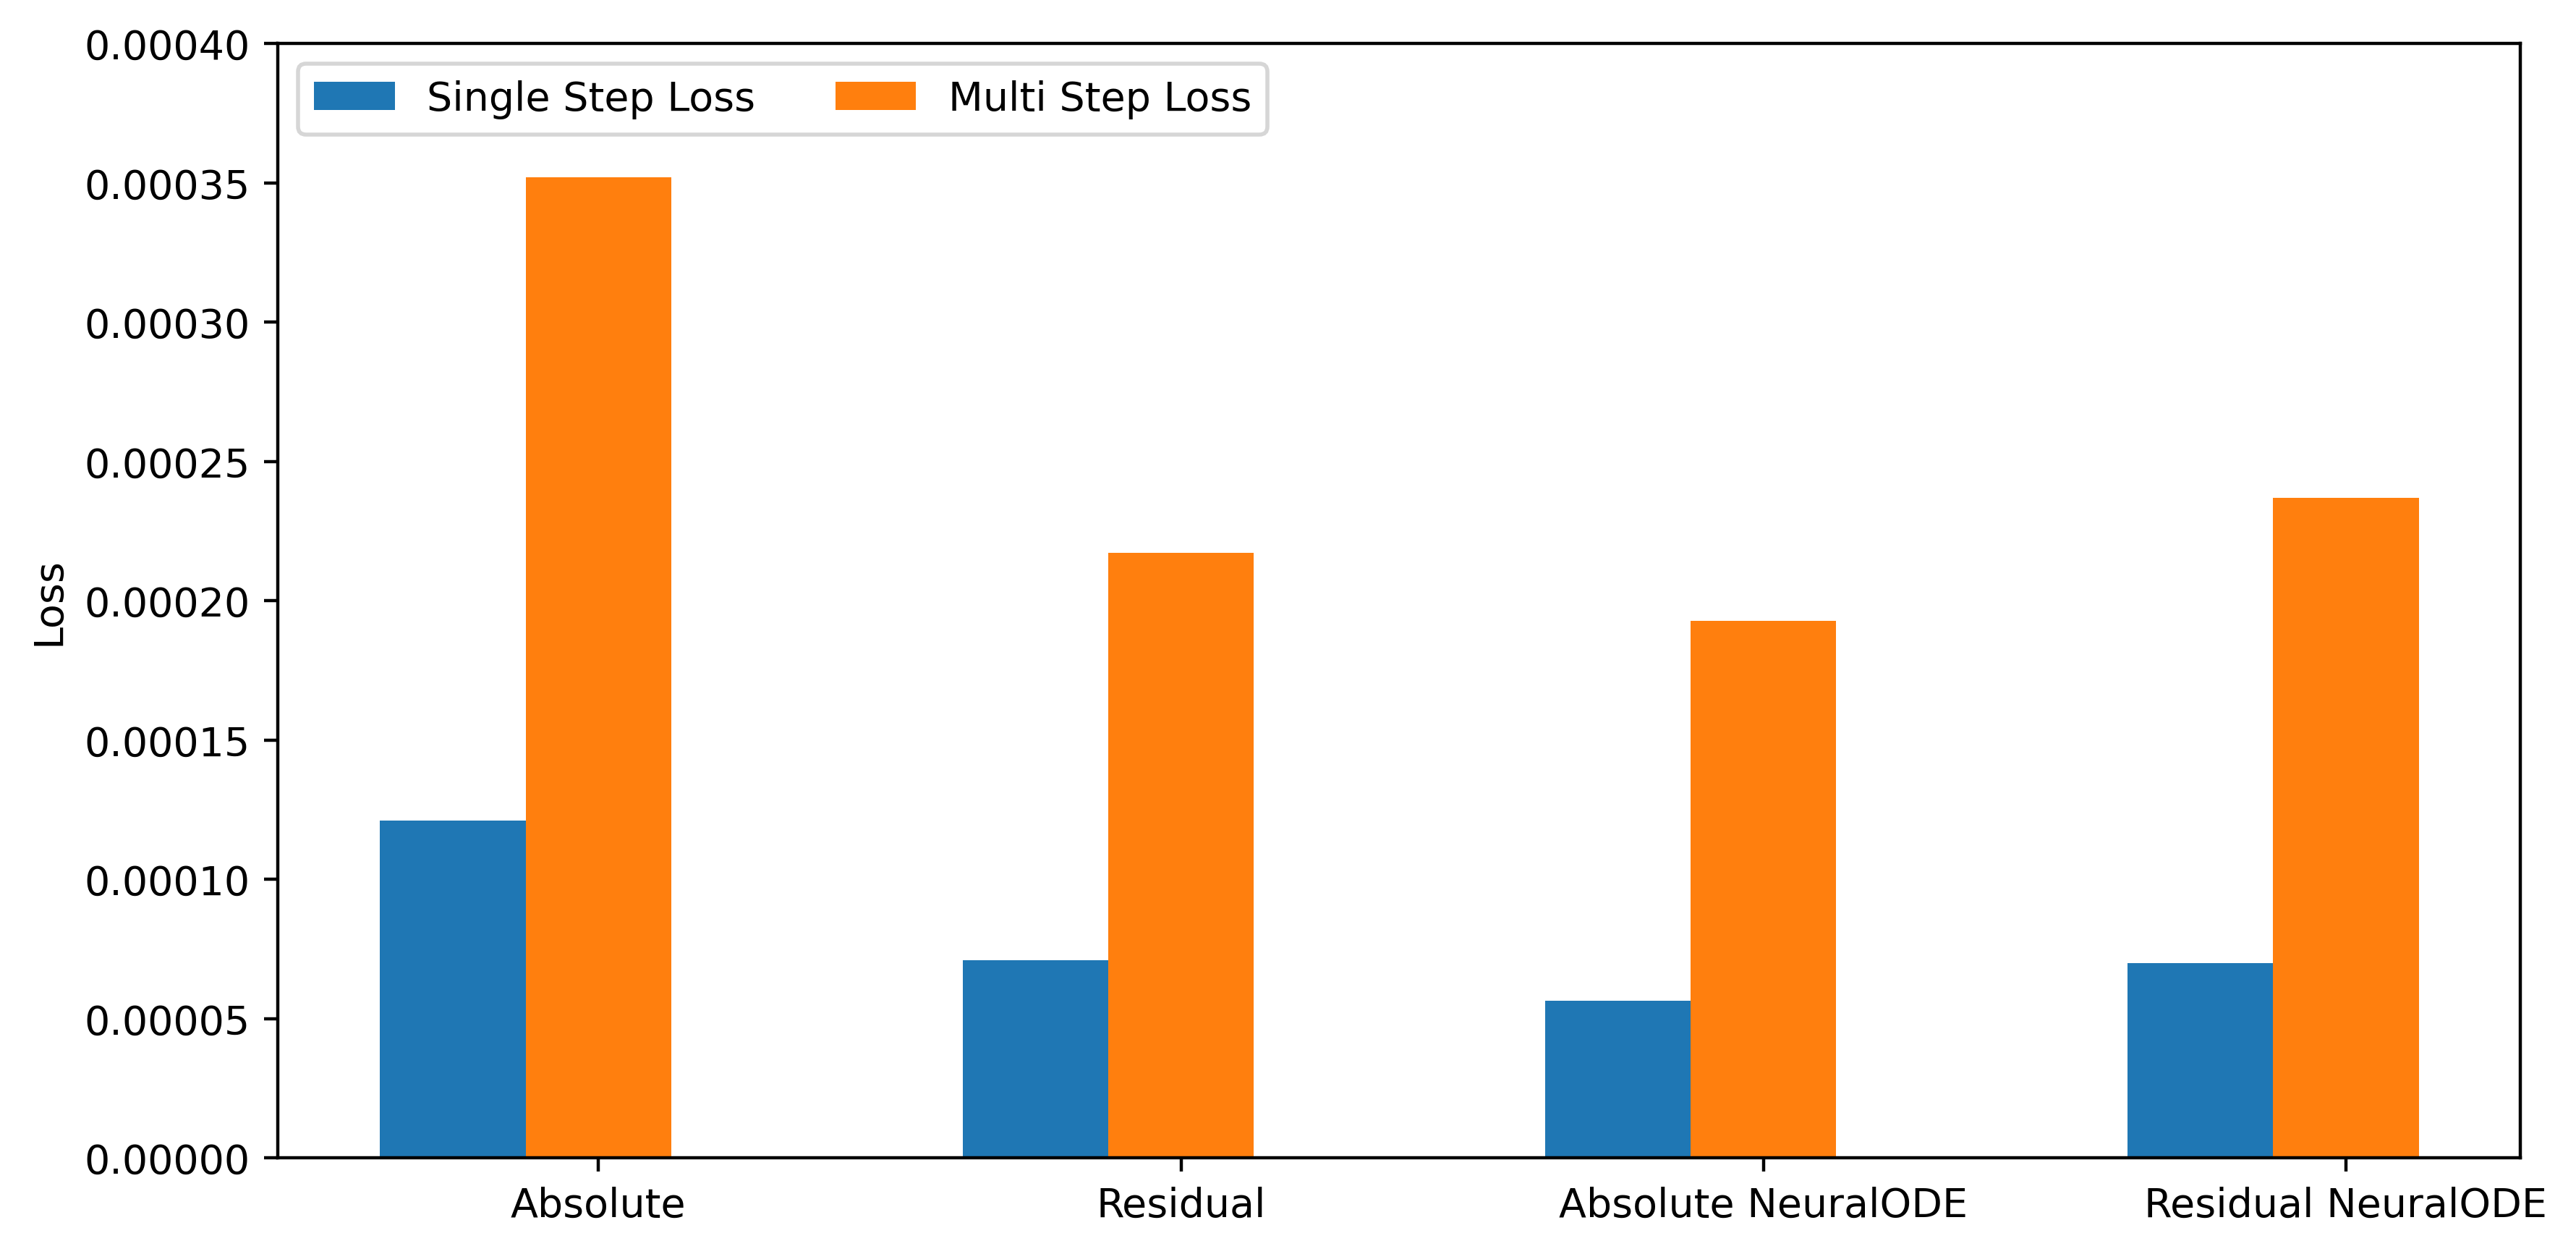

In [33]:
val_dataset = SingleStepDynamicsDataset(np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True), device=DEVICE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

num_steps = 4
val_multistep_dataset = MultiStepDynamicsDataset(np.load(os.path.join(GOOGLE_DRIVE_PATH, 'validation_data.npy'), allow_pickle=True), num_steps=num_steps, device=DEVICE)
val_multistep_loader = torch.utils.data.DataLoader(val_multistep_dataset, batch_size=len(val_multistep_dataset))

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
multistep_pose_loss = MultiStepLoss(pose_loss, discount=1).to(DEVICE)
pose_loss = SingleStepLoss(pose_loss).to(DEVICE)

losses = {
    'Single Step Loss': np.zeros(4),
    'Multi Step Loss': np.zeros(4)
}

for item in val_loader:
    losses['Single Step Loss'][0] += pose_loss(pushing_absolute_dynamics_model, item['state'], item['action'], item['next_state'])
    losses['Single Step Loss'][1] += pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])
    losses['Single Step Loss'][2] += pose_loss(absolute_neuralODE_model, item['state'], item['action'], item['next_state'])
    losses['Single Step Loss'][3] += pose_loss(residual_neuralODE_model, item['state'], item['action'], item['next_state'])
    
print("---- Single-step Loss ----")
print(f'Validation loss for absolute           dynamics model is {losses["Single Step Loss"][0]}')
print(f'Validation loss for residual           dynamics model is {losses["Single Step Loss"][1]}')
print(f'Validation loss for absolute neuralODE dynamics model is {losses["Single Step Loss"][2]}')
print(f'Validation loss for residual neuralODE dynamics model is {losses["Single Step Loss"][3]}')

for item in val_multistep_loader:
    losses['Multi Step Loss'][0] += multistep_pose_loss(pushing_absolute_dynamics_model, item['state'], item['action'], item['next_state'])
    losses['Multi Step Loss'][1] += multistep_pose_loss(pushing_residual_dynamics_model, item['state'], item['action'], item['next_state'])
    losses['Multi Step Loss'][2] += multistep_pose_loss(absolute_neuralODE_model, item['state'], item['action'], item['next_state'])
    losses['Multi Step Loss'][3] += multistep_pose_loss(residual_neuralODE_model, item['state'], item['action'], item['next_state'])

losses['Multi Step Loss'] /= 4

print("\n---- Multi-step Loss ----")
print(f'Validation loss for absolute           dynamics model is {losses["Multi Step Loss"][0] }')
print(f'Validation loss for residual           dynamics model is {losses["Multi Step Loss"][1]}')
print(f'Validation loss for absolute neuralODE dynamics model is {losses["Multi Step Loss"][2]}')
print(f'Validation loss for residual neuralODE dynamics model is {losses["Multi Step Loss"][3]}')



fig = plt.figure(figsize=(10,5), dpi=400)

models = ("Absolute", "Residual", "Absolute NeuralODE", "Residual NeuralODE")
x = np.arange(4)
width = 0.25  # the width of the bars
multiplier = 0

for attribute, values in losses.items():
    offset = width * multiplier
    rects = plt.bar(x + offset, values, width, label=attribute)
    # plt.bar_label(rects, padding=3)
    multiplier += 1

plt.ylabel('Loss')
plt.xticks(x + width, models)
plt.legend(loc='upper left', ncols=2)
plt.ylim(0.0, 0.0004)
# plt.ylim(1e-5, 1e-3)
# plt.yscale("log")

plt.show()

## Gridsearch

In [16]:
train_loader, val_loader = process_data_single_step(collected_data, device=DEVICE)

pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
pose_loss = SingleStepLoss(pose_loss).to(DEVICE)

# train_loader, val_loader = process_data_multiple_step(collected_data, batch_size=500, device=DEVICE)

# pose_loss = SE2PoseLoss(block_width=0.1, block_length=0.1).to(DEVICE)
# pose_loss = MultiStepLoss(pose_loss, discount=0.9).to(DEVICE)

result_dict, options = neuralODE_gridsearch(train_loader, val_loader,
                                            loss_fn=pose_loss, save_dir=GOOGLE_DRIVE_PATH,
                                            state_dim=3, action_dim=3,
                                            residual=True, device=DEVICE,
                                            num_epochs=100, lr=1e-2)

n_steps=2, solver=dopri5, hidden_dim=4


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=8.892E-03, val_loss=9.329E-03
n_steps=2, solver=dopri5, hidden_dim=32


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.052E-04, val_loss=1.884E-04
n_steps=2, solver=dopri5, hidden_dim=100


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=9.206E-05, val_loss=8.027E-05
n_steps=6, solver=dopri5, hidden_dim=4


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.020E-03, val_loss=2.240E-03
n_steps=6, solver=dopri5, hidden_dim=32


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.014E-04, val_loss=2.076E-04
n_steps=6, solver=dopri5, hidden_dim=100


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=1.225E-04, val_loss=1.079E-04
n_steps=10, solver=dopri5, hidden_dim=4


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.187E-03, val_loss=2.298E-03
n_steps=10, solver=dopri5, hidden_dim=32


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.286E-04, val_loss=2.316E-04
n_steps=10, solver=dopri5, hidden_dim=100


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=9.200E-05, val_loss=7.807E-05
n_steps=2, solver=rk4, hidden_dim=4


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.221E-03, val_loss=2.414E-03
n_steps=2, solver=rk4, hidden_dim=32


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.993E-04, val_loss=3.333E-04
n_steps=2, solver=rk4, hidden_dim=100


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=1.205E-04, val_loss=1.274E-04
n_steps=6, solver=rk4, hidden_dim=4


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.129E-03, val_loss=2.275E-03
n_steps=6, solver=rk4, hidden_dim=32


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.658E-04, val_loss=2.786E-04
n_steps=6, solver=rk4, hidden_dim=100


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=8.457E-05, val_loss=7.354E-05
n_steps=10, solver=rk4, hidden_dim=4


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=2.517E-03, val_loss=2.633E-03
n_steps=10, solver=rk4, hidden_dim=32


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=1.317E-04, val_loss=1.156E-04
n_steps=10, solver=rk4, hidden_dim=100


  0%|          | 0/100 [00:00<?, ?it/s]

	train_loss=9.626E-05, val_loss=9.278E-05


In [18]:
np.save(os.path.join(GOOGLE_DRIVE_PATH, "grid_search_results_singlestep_residual2"), (result_dict, options), allow_pickle=True)

/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [40]:
result_dict, options = np.load(os.path.join(GOOGLE_DRIVE_PATH, "grid_search_results_singlestep.npy"), allow_pickle=True)

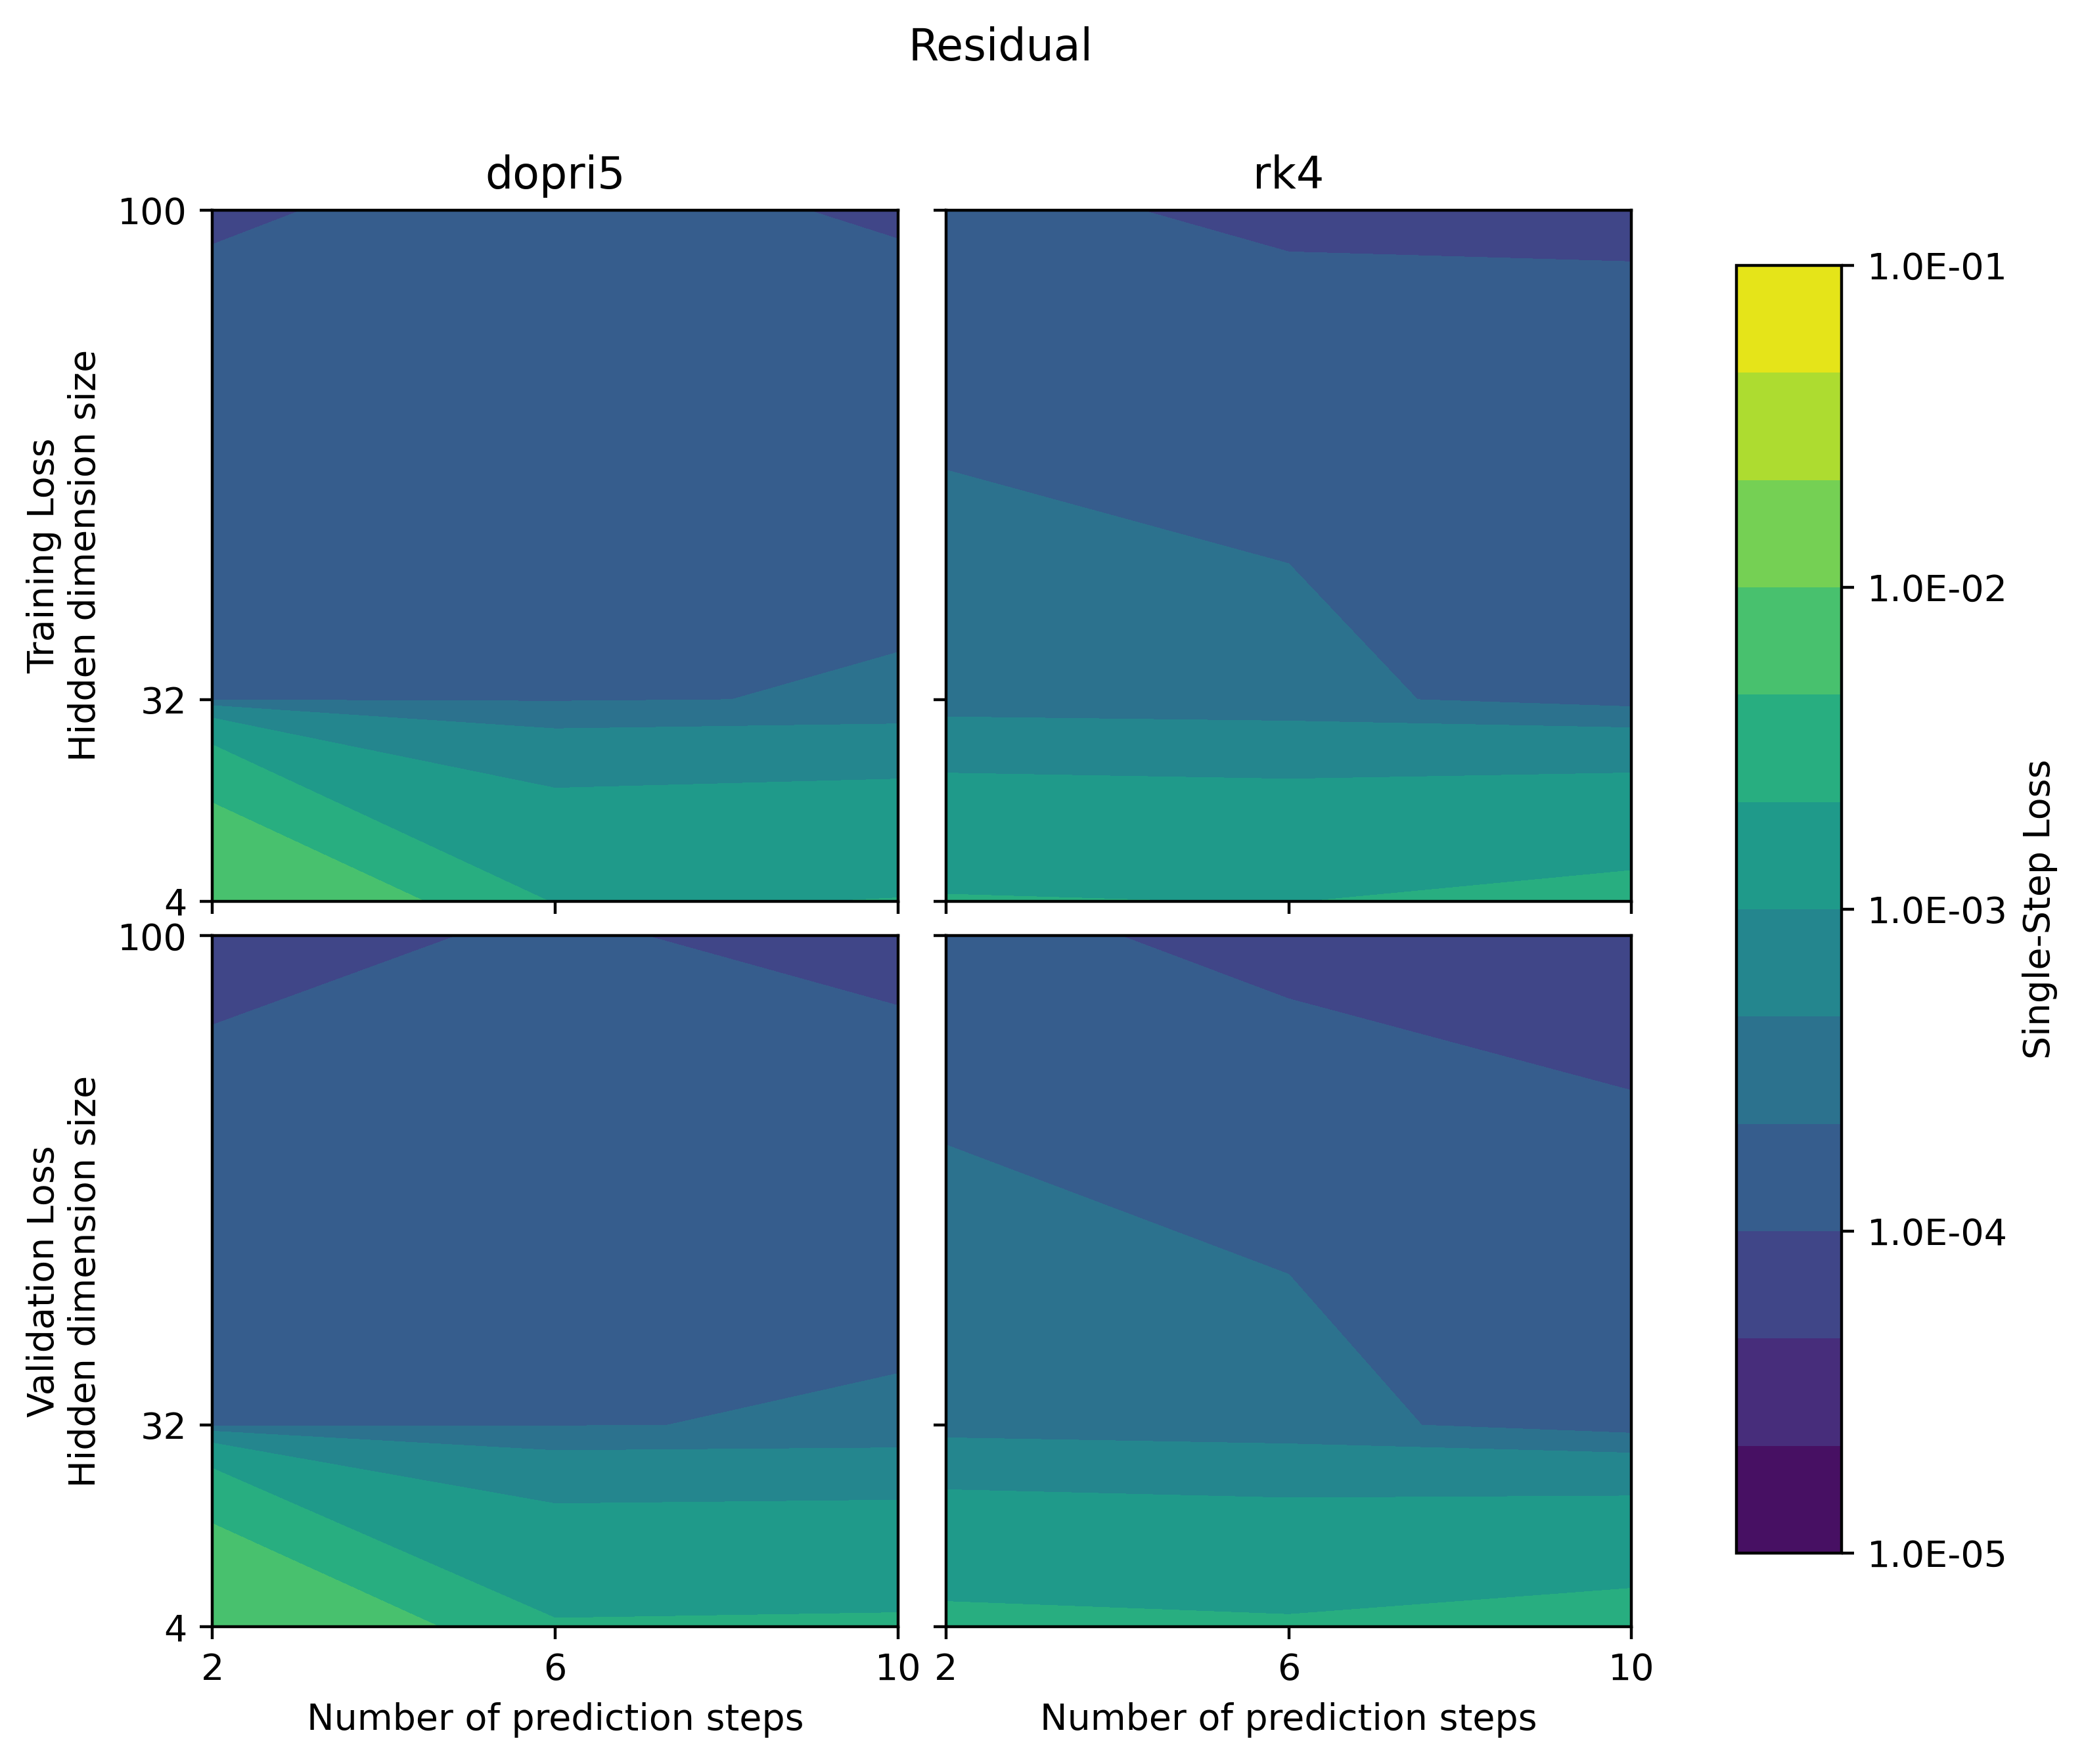

In [23]:
import matplotlib.colors as colors
solvers, n_steps, hidden_dims = options
X, Y = np.meshgrid(n_steps, hidden_dims)

n_levels_per_section = 3
log_max = -1
log_min = -5

n_levels= (log_max-log_min)*n_levels_per_section + 1

fig, axs = plt.subplots(2, 2, figsize=(8,7), dpi=400)
fig.suptitle("Residual")

max_loss = 0.0
for _, losses in result_dict.items():
    if max_loss < np.max(losses):
        max_loss = np.max(losses)

for i, (key, losses) in enumerate(result_dict.items()):
    axs[0,i].set_title(key)
    axs[1,i].set_xlabel("Number of prediction steps")
    axs[0,i].set_ylabel("Training Loss\nHidden dimension size")
    axs[1,i].set_ylabel("Validation Loss\nHidden dimension size")
    m = axs[0,i].contourf(X, Y, losses[:,:,0].T, cmap='viridis', levels=np.logspace(log_min, log_max, n_levels), norm=colors.LogNorm(vmin=10**log_min, vmax=10**log_max), vmax=10**log_max, vmin=10**log_min)
    m = axs[1,i].contourf(X, Y, losses[:,:,1].T, cmap='viridis', levels=np.logspace(log_min, log_max, n_levels), norm=colors.LogNorm(vmin=10**log_min, vmax=10**log_max), vmax=10**log_max, vmin=10**log_min)

plt.setp(axs, xlim=(n_steps[0],n_steps[-1]), ylim=(hidden_dims[0],hidden_dims[-1]), xticks=n_steps, yticks=hidden_dims)


for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(right=0.8, hspace=0.05, wspace=0.07)
ticks = np.logspace(log_min, log_max, int((n_levels-1)/n_levels_per_section)+1)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(m, cax=cbar_ax, ticks=ticks, format='%.1E', label='Single-Step Loss')

plt.show()

In [ ]:
### RK4
result_dict, options = np.load(os.path.join(GOOGLE_DRIVE_PATH, "grid_search_results_multistep_rk4.npy"), allow_pickle=True)

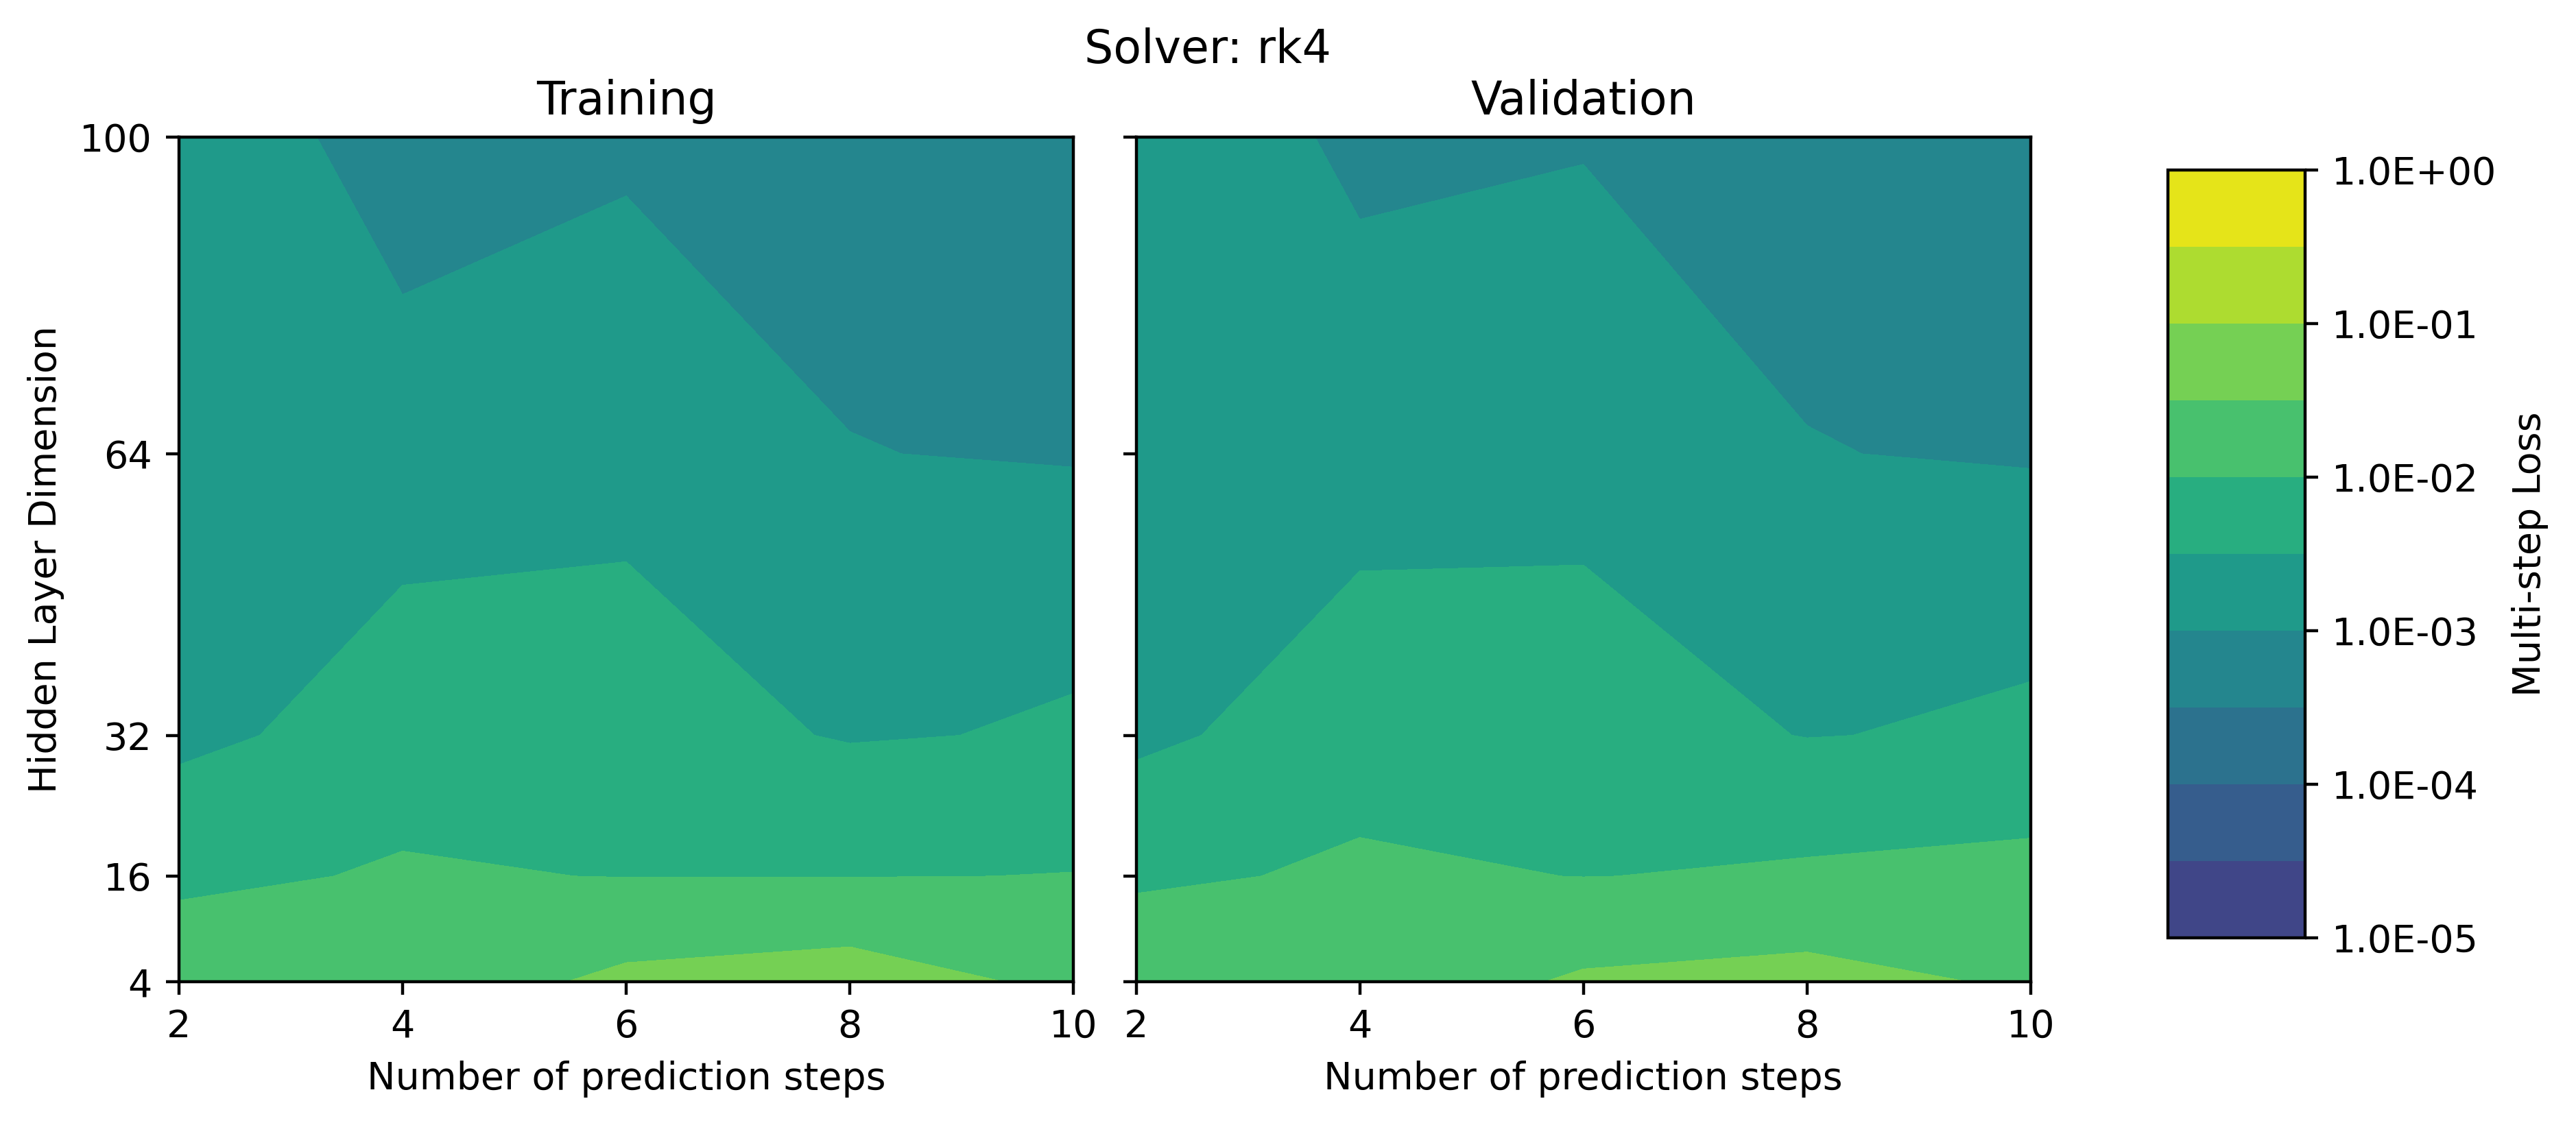

In [ ]:
import matplotlib.colors as colors
solvers, n_steps, hidden_dims = options
solver = solvers[0]
X, Y = np.meshgrid(n_steps, hidden_dims)
n_levels=11

fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=400)
fig.suptitle("Solver: %s" % solver)

max_loss = np.max(result_dict[solver])

axs[0].set_title("Training")
axs[1].set_title("Validation")

axs[0].set_xlabel("Number of prediction steps")
axs[1].set_xlabel("Number of prediction steps")
axs[0].set_ylabel("Hidden Layer Dimension")

m = axs[0].contourf(X, Y, result_dict[solver][:,:,0].T, levels=np.logspace(-5, 0, n_levels), cmap='viridis', norm=colors.LogNorm(vmin=1e-5, vmax=1e0), vmax=1e0, vmin=1e-6)
m = axs[1].contourf(X, Y, result_dict[solver][:,:,1].T, levels=np.logspace(-5, 0, n_levels), cmap='viridis', norm=colors.LogNorm(vmin=1e-5, vmax=1e0), vmax=1e0, vmin=1e-6)

plt.setp(axs, xlim=(n_steps[0],n_steps[-1]), ylim=(hidden_dims[0],hidden_dims[-1]), xticks=n_steps, yticks=hidden_dims)

for ax in axs.flat:
    ax.label_outer()

fig.subplots_adjust(right=0.8, hspace=0.05, wspace=0.07)
ticks = np.logspace(-5, 0, int((n_levels+1)/2))
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(m, cax=cbar_ax, ticks=ticks, format='%.1E', label='Multi-step Loss')

plt.show()

## Use the Learned Dynamics Model for Planning and Controls


### 4.1 - Obstacle-Free Pushing

In [ ]:
residual_neuralODE_model = Residual_ODEnet(3,3,2)
residual_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_residual_dynamics_model.pt')))

<All keys matched successfully>

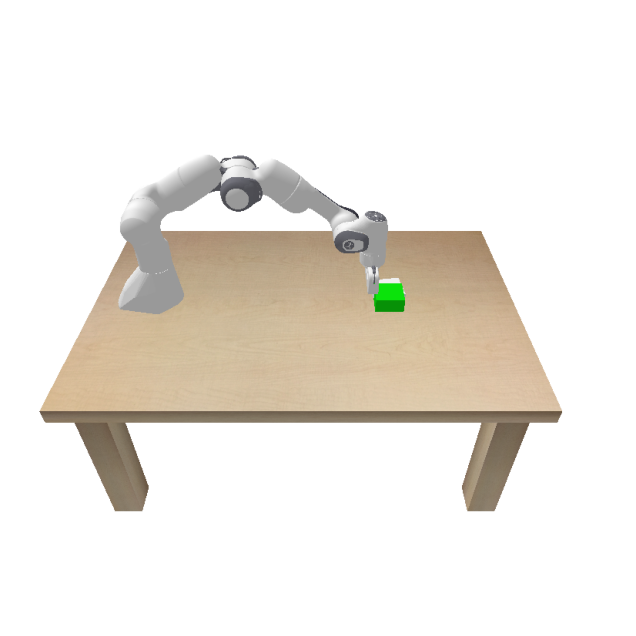

100%|██████████| 20/20 [01:32<00:00,  4.63s/it]

GOAL REACHED: True


In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, residual_neuralODE_model, free_pushing_cost_function, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
plt.close(fig)


### Pushing with Obstacles

In [35]:
absolute_neuralODE_model = Absolute_ODEnet(3,3,10).to('cpu')
absolute_neuralODE_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, 'neuralODE_absolute_dynamics_model.pt')))

<All keys matched successfully>

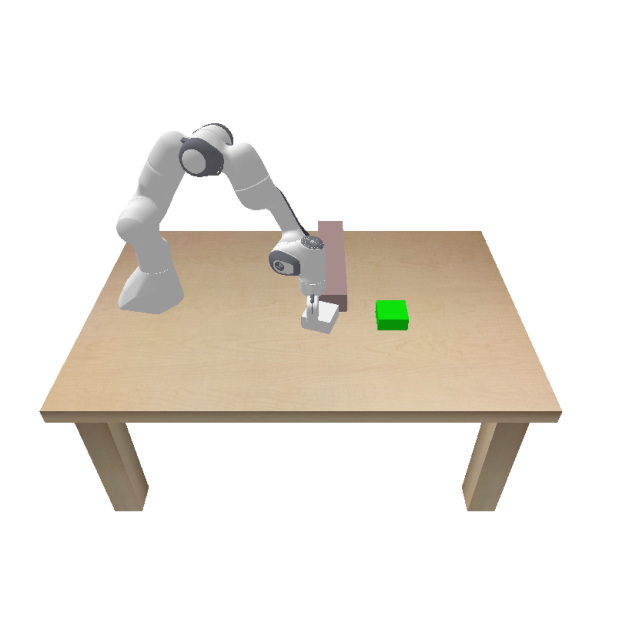

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, absolute_neuralODE_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20)
env.reset()

state_0 = env.reset()
state = state_0

num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
# Evaluate state
plt.close(fig)